# 1. Import Library dan Datset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Clustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
#Impor Data Ritel Online yang berisi transaksi dari 12/01/2010 dan 12/09/2011
df = pd.read_excel('rfm_dataset.xlsx')
df.head()

,DATE,CUSTOMER,BR/BKJ,RASPBERRY,BLUEBERRY,FROZEN RASPBERRY,CAPE GOOSEBERRY,TEA,JAM,NO NOTA,PRICE '/GRS,TOTAL HARGA
0,2023-11-01,PT. Graha Alam Lestari Pastry po 132401,BR,2000.0,NaN,NaN,NaN,NaN,NaN,16914.0,440,880000
1,2023-11-01,PT. Graha Alam Lestari Pastry po 132401,BR,NaN,750.0,NaN,NaN,NaN,NaN,16914.0,550,412500
2,2023-11-01,PT. Graha Alam Lestari Koral po 132401,BR,500.0,NaN,NaN,NaN,NaN,NaN,16915.0,440,220000
3,2023-11-01,Melia Bali,BR,2000.0,NaN,NaN,NaN,NaN,NaN,16916.0,440,880000
4,2023-11-01,Folie,BR,500.0,NaN,NaN,NaN,NaN,NaN,16917.0,440,220000


# 2. Cleaning Dataset

In [3]:
#Melakukan pengecekan shape (columns and rows) dari dataset
df.shape

(346, 12)

In [4]:
#Check missing value pada dataset
df.isnull().sum(axis=0)

DATE                  0
CUSTOMER              0
BR/BKJ                0
RASPBERRY            31
BLUEBERRY           344
FROZEN RASPBERRY    339
CAPE GOOSEBERRY     325
TEA                 345
JAM                 346
NO NOTA               9
PRICE '/GRS           0
TOTAL HARGA           0
dtype: int64

In [5]:
df['RASPBERRY'].fillna(0, inplace=True)
df['BLUEBERRY'].fillna(0, inplace=True)
df['FROZEN RASPBERRY'].fillna(0, inplace=True)
df['CAPE GOOSEBERRY'].fillna(0, inplace=True)
df['TEA'].fillna(0, inplace=True)
df['JAM'].fillna(0, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_26596\175551796.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RASPBERRY'].fillna(0, inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_26596\175551796.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

In [6]:
df.isnull().sum(axis=0)

DATE                0
CUSTOMER            0
BR/BKJ              0
RASPBERRY           0
BLUEBERRY           0
FROZEN RASPBERRY    0
CAPE GOOSEBERRY     0
TEA                 0
JAM                 0
NO NOTA             9
PRICE '/GRS         0
TOTAL HARGA         0
dtype: int64

In [7]:
df = df.dropna(subset=['NO NOTA'])

In [8]:
df.shape

(337, 12)

In [9]:
df.isnull().sum(axis=0)

DATE                0
CUSTOMER            0
BR/BKJ              0
RASPBERRY           0
BLUEBERRY           0
FROZEN RASPBERRY    0
CAPE GOOSEBERRY     0
TEA                 0
JAM                 0
NO NOTA             0
PRICE '/GRS         0
TOTAL HARGA         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337 entries, 0 to 345
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              337 non-null    datetime64[ns]
 1   CUSTOMER          337 non-null    object        
 2   BR/BKJ            337 non-null    object        
 3   RASPBERRY         337 non-null    float64       
 4   BLUEBERRY         337 non-null    float64       
 5   FROZEN RASPBERRY  337 non-null    float64       
 6   CAPE GOOSEBERRY   337 non-null    float64       
 7   TEA               337 non-null    float64       
 8   JAM               337 non-null    float64       
 9   NO NOTA           337 non-null    float64       
 10  PRICE '/GRS       337 non-null    int64         
 11  TOTAL HARGA       337 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 34.2+ KB


# 3. RFM Modelling

- Recency = Latest Date - Last Inovice Data
- Frequency = count of invoice no. of transaction(s)
- Monetary = Sum of Total 

In [11]:
import datetime as dt

In [12]:
df['DATE'].max()

Timestamp('2023-11-29 00:00:00')

In [13]:
#Menetapkan tgl terbaru 2023-11-30, hal ini untuk menghitung jumlah hari sejak tanggal invoice terakhir
Latest_Date = dt.datetime(2023,11,30)

In [14]:
#Membuat RFM Modelling scores untuk setiap customet
rfm_scores = df.groupby('CUSTOMER').agg({
    #Recency
    'DATE': lambda x: (Latest_Date - x.max()).days,

    #Frequency
    'NO NOTA': lambda x: len(x),

    #Monetary
    'TOTAL HARGA': lambda x: x.sum()
})

In [15]:
rfm_scores.head()

,DATE,NO NOTA,TOTAL HARGA
CUSTOMER,,,
Bintang Hayam Wuruk po 00233,24,2,509000
Bintang Hayam Wuruk po 01602,17,2,509000
Bintang Hayam Wuruk po 03293,10,1,425000
Bintang Hayam Wuruk po 05659,3,1,637500
Bintang Seminyak,3,3,1487500


In [16]:
#Convert data type dari InvoiceDate menjadi int
rfm_scores['DATE'] = rfm_scores['DATE'].astype(int)

In [17]:
#Rename column pada rfm_scores
rfm_scores.rename(columns={
    'DATE': 'Recency',
    'NO NOTA': 'Frequency',
    'TOTAL HARGA': 'Monetary'
}, inplace=True)

In [18]:
#Tampilkan dan reset index
rfm_scores.reset_index().head()

,CUSTOMER,Recency,Frequency,Monetary
0,Bintang Hayam Wuruk po 00233,24,2,509000
1,Bintang Hayam Wuruk po 01602,17,2,509000
2,Bintang Hayam Wuruk po 03293,10,1,425000
3,Bintang Hayam Wuruk po 05659,3,1,637500
4,Bintang Seminyak,3,3,1487500


In [19]:
rfm_scores.shape

(202, 3)

In [20]:
#Split menjadi empat segmen menggunakan kuartil
split = rfm_scores.quantile(q=[0.25,0.5,0.75])
split = split.to_dict()

In [21]:
split

{'Recency': {0.25: 5.0, 0.5: 13.0, 0.75: 22.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 425000.0, 0.5: 440000.0, 0.75: 831875.0}}

In [22]:
#Fungsi untuk membuat R, F and M segments

#Recency
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

#Frequency  
def FScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#Monetary 
def MScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [23]:
#Hitung & Tambahkan kolom nilai segmen R, F dan M di kumpulan data yang ada untuk menampilkan nilai segmen R, F dan M
rfm_scores['R'] = rfm_scores['Recency'].apply(RScoring, args=('Recency',split,))
rfm_scores['F'] = rfm_scores['Frequency'].apply(FScoring, args=('Frequency',split,))
rfm_scores['M'] = rfm_scores['Monetary'].apply(MScoring, args=('Monetary',split,))
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M
CUSTOMER,,,,,,
Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2
Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2
Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4
Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2
Bintang Seminyak,3,3,1487500,1,1,1


In [24]:
#Hitung dan tambahkan pada column baru RFMGroup untuk melihat kombinasi dari rfm score
rfm_scores['RFMGroup'] = rfm_scores.R.map(str) + rfm_scores.F.map(str) + rfm_scores.M.map(str)

In [25]:
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup
CUSTOMER,,,,,,,
Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2,422
Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2,322
Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4,244
Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2,142
Bintang Seminyak,3,3,1487500,1,1,1,111


In [26]:
#Hitung dan tambahkan pada column baru RFMScore untuk menampilkan total sum dari RFMGroup values
rfm_scores['RFMScore'] = rfm_scores[['R', 'F', 'M']].sum(axis=1)
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CUSTOMER,,,,,,,,
Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2,422,8
Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2,322,7
Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4,244,10
Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2,142,7
Bintang Seminyak,3,3,1487500,1,1,1,111,3


In [27]:
# RFMScore 1 diberikan Single-time
# RFMScore 2-4 diberikan Occasional
# RFMScore 5-9 diberikan Potential
# RFMScore 10-12 diberikan Loyal

# Menetapkan batas untuk kategori RFMScore
bins = [0, 1, 5, 10, 12]
# Menetapkan label untuk masing-masing kategori
labels = ['Single-time', 'Occasional', 'Potential', 'Loyal']

# Menetapkan Loyalty Level untuk setiap customer berdasarkan RFMScore
rfm_scores['RFM_Loyalty_Level'] = pd.cut(rfm_scores['RFMScore'], bins=bins, labels=labels, right=False)

# Menampilkan hasil
rfm_scores.reset_index().head()


# #Menetapkan Loyalty Level untuk masing-masing customer
# Loyalty_Level = ['Single-time', 'Occasional', 'Potential', 'Loyal']
# Score_cuts = pd.qcut(rfm_scores.RFMScore, q = 4, labels = Loyalty_Level)
# rfm_scores['RFM_Loyalty_Level'] = Score_cuts.values
# rfm_scores.reset_index().head()

,CUSTOMER,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2,422,8,Potential
1,Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2,322,7,Potential
2,Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4,244,10,Loyal
3,Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2,142,7,Potential
4,Bintang Seminyak,3,3,1487500,1,1,1,111,3,Occasional


In [28]:
#Validate the data for RFMGroup = 444 adalah loyal
loyal=rfm_scores[rfm_scores['RFM_Loyalty_Level']=='Loyal'].sort_values('Monetary', ascending=False).reset_index().head(30)
loyal

,CUSTOMER,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,COD - Ruster (grade B),29,1,600000,4,4,2,442,10,Loyal
1,COD - Frencha - uluwatu,27,1,600000,4,4,2,442,10,Loyal
2,The Mulia Pastry po31542,17,1,440000,3,4,3,343,10,Loyal
3,Bulgary po 178882,29,1,440000,4,4,3,443,11,Loyal
4,The Mulia Commisary po 30226,29,1,440000,4,4,3,443,11,Loyal
5,The Mulia Commisary po 30496,27,1,440000,4,4,3,443,11,Loyal
6,The Mulia Commisary po 30756,24,1,440000,4,4,3,443,11,Loyal
7,Hyatt Andaz po 31937,17,1,440000,3,4,3,343,10,Loyal
8,Hyatt Andaz po 31668,24,1,440000,4,4,3,443,11,Loyal
9,The Mulia Commisary po 31441,20,1,440000,3,4,3,343,10,Loyal


In [29]:
#Validate the data for RFMGroup = 444 adalah loyal
potential=rfm_scores[rfm_scores['RFM_Loyalty_Level']=='Potential'].sort_values('Monetary', ascending=False).reset_index().head(30)
potential

,CUSTOMER,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,The Mulia Commisary po 32947,6,1,1320000,2,4,1,241,7,Potential
1,COD - Cocoku,19,2,1320000,3,2,1,321,6,Potential
2,PT. Graha Alam Lestari Pastry po 132401,29,2,1292500,4,2,1,421,7,Potential
3,COD - Indigo,10,2,1160000,2,2,1,221,5,Potential
4,The Mulia Commisary po33105,3,1,1100000,1,4,1,141,6,Potential
5,PT. Graha Alam Lestari Pastry po 134890,6,1,1100000,2,4,1,241,7,Potential
6,Pepito Echo Beach,6,2,1062500,2,2,1,221,5,Potential
7,COD - Wood/ pick up,29,2,990000,4,2,1,421,7,Potential
8,Papaya po 0183,22,2,985000,3,2,1,321,6,Potential
9,Bintang Ubud po 01071,19,2,917500,3,2,1,321,6,Potential


In [30]:
#Validate the data for RFMGroup = 444 adalah loyal
occasional=rfm_scores[rfm_scores['RFM_Loyalty_Level']=='Occasional'].sort_values('Monetary', ascending=False).reset_index().head(30)
occasional

,CUSTOMER,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,Melia Bali,1,13,11440000,1,1,1,111,3,Occasional
1,COD - Alive,1,6,5510000,1,1,1,111,3,Occasional
2,COD - Butterman,1,10,4180000,1,1,1,111,3,Occasional
3,Canggu Station,1,5,2709375,1,1,1,111,3,Occasional
4,Pepito SWJ,1,5,2443750,1,1,1,111,3,Occasional
5,Pepito Peliatan,5,4,2443750,1,1,1,111,3,Occasional
6,COD - Usha,3,6,2310000,1,1,1,111,3,Occasional
7,Delta,5,4,2178125,1,1,1,111,3,Occasional
8,Popular Deli,1,5,2125000,1,1,1,111,3,Occasional
9,Pepito Andong,5,4,2125000,1,1,1,111,3,Occasional


In [31]:
#Validate the data for RFMGroup = 444 adalah loyal
single_time=rfm_scores[rfm_scores['RFM_Loyalty_Level']=='Single-time'].sort_values('Monetary', ascending=False).reset_index().head(30)
single_time

,CUSTOMER,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level


In [32]:
rfm_scores.shape

(202, 9)

In [33]:
# Aggregation on RFM Score on the dataset
rfm_scores[["RFMScore", "Recency", "Frequency", "Monetary"]].groupby("RFMScore").agg(["mean", "max", "min"])

Recency         Frequency              Monetary                  
               mean max min      mean max min          mean       max     min
RFMScore                                                                     
3          2.700000   5   1  5.050000  13   3  2.653194e+06  11440000  990000
4          7.400000  13   5  3.500000   4   3  1.383250e+06   1945000  660000
5          7.166667  10   5  2.500000   3   2  8.287500e+05   1160000  660000
6          8.666667  22   1  1.666667   2   1  7.977083e+05   1320000  440000
7         11.090909  29   1  1.409091   2   1  7.439602e+05   1320000  440000
8         11.250000  29   1  1.187500   2   1  6.182188e+05    880000  440000
9          9.785714  27   1  1.000000   1   1  4.596429e+05    880000  220000
10        14.029412  29   6  1.000000   1   1  3.866176e+05    600000  220000
11        21.416667  29  15  1.000000   1   1  3.536111e+05    440000  140000
12        26.611111  29  24  1.000000   1   1  3.322222e+05    425000  140000

# 4. K-means Clustering

In [34]:
# Scaling Recency, Frequency, Monetary and RFMScore columns
scaler = StandardScaler()

# Subset
rfm_scaled = rfm_scores[['Recency','Frequency','Monetary','RFMScore']]
rfm_scaled = scaler.fit_transform(rfm_scaled)
rfm_scaled = pd.DataFrame(rfm_scaled, columns = ['Recency','Frequency','Monetary','RFMScore'])
rfm_scaled.head()

,Recency,Frequency,Monetary,RFMScore
0,1.183731,0.221542,-0.246637,-0.129329
1,0.404496,0.221542,-0.246637,-0.492169
2,-0.374738,-0.446391,-0.330999,0.596351
3,-1.153972,-0.446391,-0.117584,-0.492169
4,-1.153972,0.889476,0.736078,-1.943530


## 4.1 Evaluasi klaster optimal menggunakan Elbow Method

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kme

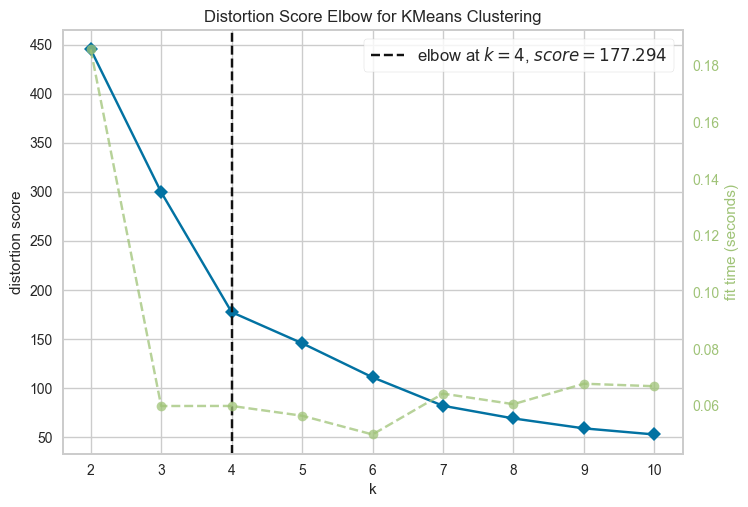

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
# Nilai k untuk menghitung skor siluet
# Jika bilangan bulat tunggal ditentukan, maka rentang (2,k) akan dihitung
elbow_method = KElbowVisualizer(KMeans(), k = 10, colors = 'viridis') # range = [2, 10]
elbow_method.fit(rfm_scaled)
elbow_method.show()

In [36]:
# Fit Kmeans at n_clusters = 4
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10,max_iter=50,verbose=0)
kmeans.fit(rfm_scaled)

KMeans(max_iter=50, n_clusters=4, n_init=10)

In [37]:
# Assigning Clusters
rfm_scores['Clusters_Kmeans'] = kmeans.labels_
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Clusters_Kmeans
CUSTOMER,,,,,,,,,,
Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2,422,8,Potential,3
Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2,322,7,Potential,1
Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4,244,10,Loyal,1
Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2,142,7,Potential,1
Bintang Seminyak,3,3,1487500,1,1,1,111,3,Occasional,0


C:\Users\USER\AppData\Local\Temp\ipykernel_26596\1653252555.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = rfm_scores, x = "Clusters_Kmeans", y = "Recency" , palette = 'YlOrBr', ax = ax[0])
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USER\AppData\Local\Programs\Python\

Text(0, 0.5, 'Monetary')

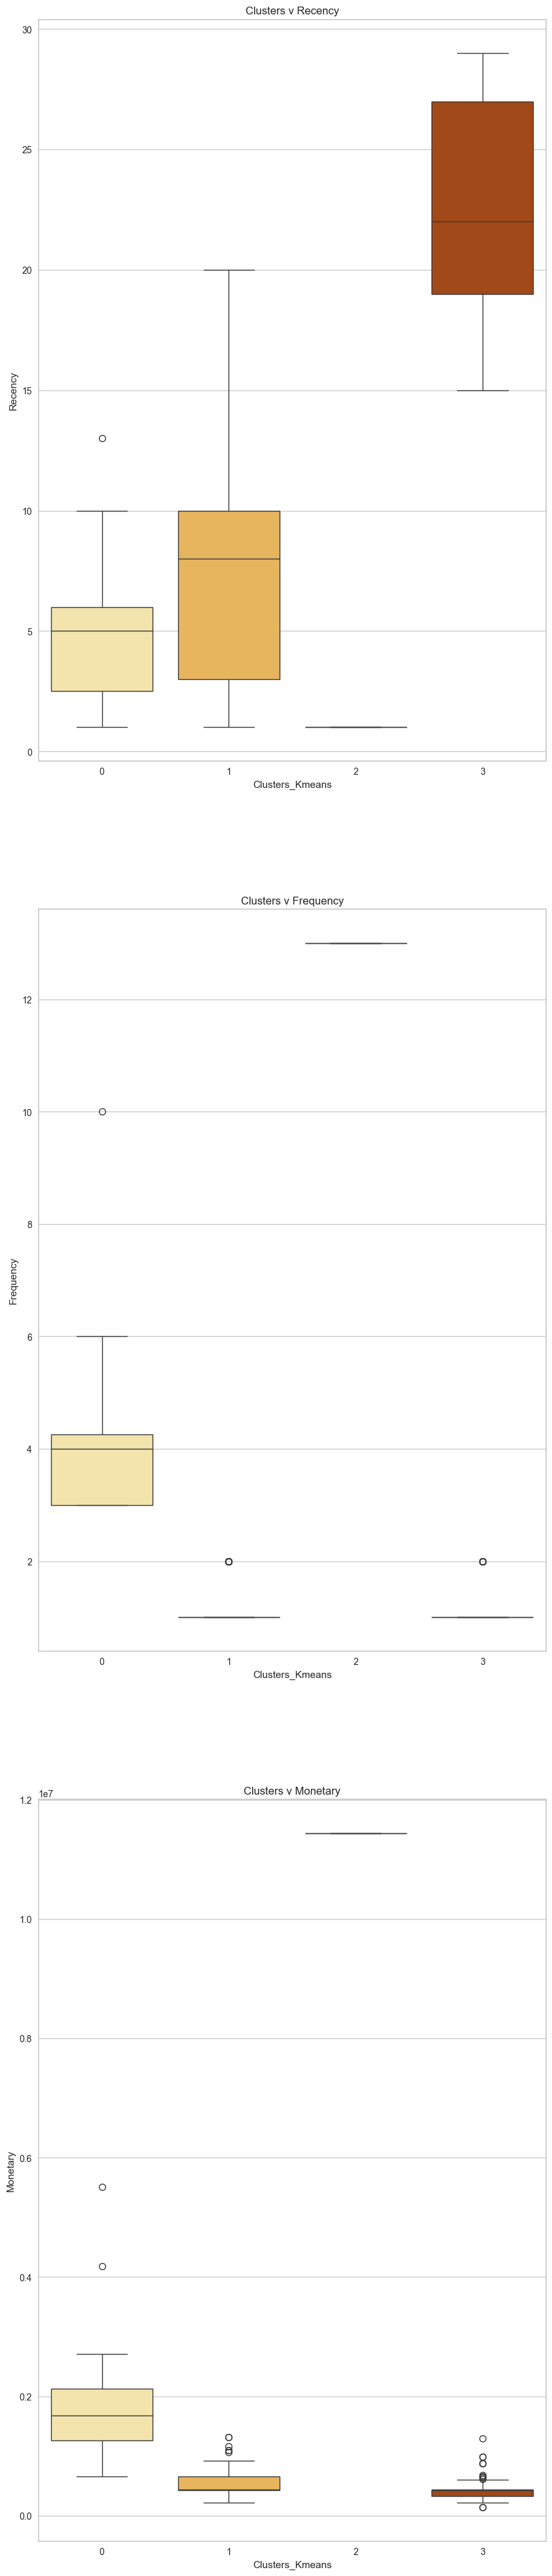

In [38]:
# Plot
fig, ax = plt.subplots(3, 1, figsize = (10, 50))

# Recency
sns.boxplot(data = rfm_scores, x = "Clusters_Kmeans", y = "Recency" , palette = 'YlOrBr', ax = ax[0])
ax[0].set_title('Clusters v Recency')
ax[0].set_ylabel('Recency')

# Frequency
sns.boxplot(data = rfm_scores, x = "Clusters_Kmeans", y = "Frequency" , palette = 'YlOrBr', ax = ax[1])
ax[1].set_title('Clusters v Frequency')
ax[1].set_ylabel('Frequency')

# Monetary
sns.boxplot(data = rfm_scores, x = "Clusters_Kmeans", y = "Monetary" , palette = 'YlOrBr', ax = ax[2])
ax[2].set_title('Clusters v Monetary')
ax[2].set_ylabel('Monetary')

In [39]:
rfm_stats = rfm_scores[["Clusters_Kmeans","RFMScore", "Recency", "Frequency", "Monetary"]].groupby("Clusters_Kmeans").agg(["mean"])
rfm_stats.columns = ["RFM_Score_Mean", "Recency_Mean", "Frequency_Mean", "Monetary_Mean"]
rfm_stats

,RFM_Score_Mean,Recency_Mean,Frequency_Mean,Monetary_Mean
Clusters_Kmeans,,,,
0,3.500000,4.656250,4.125000,1.794887e+06
1,8.152941,7.811765,1.164706,5.479882e+05
2,3.000000,1.000000,13.000000,1.144000e+07
3,10.476190,22.452381,1.107143,4.401146e+05


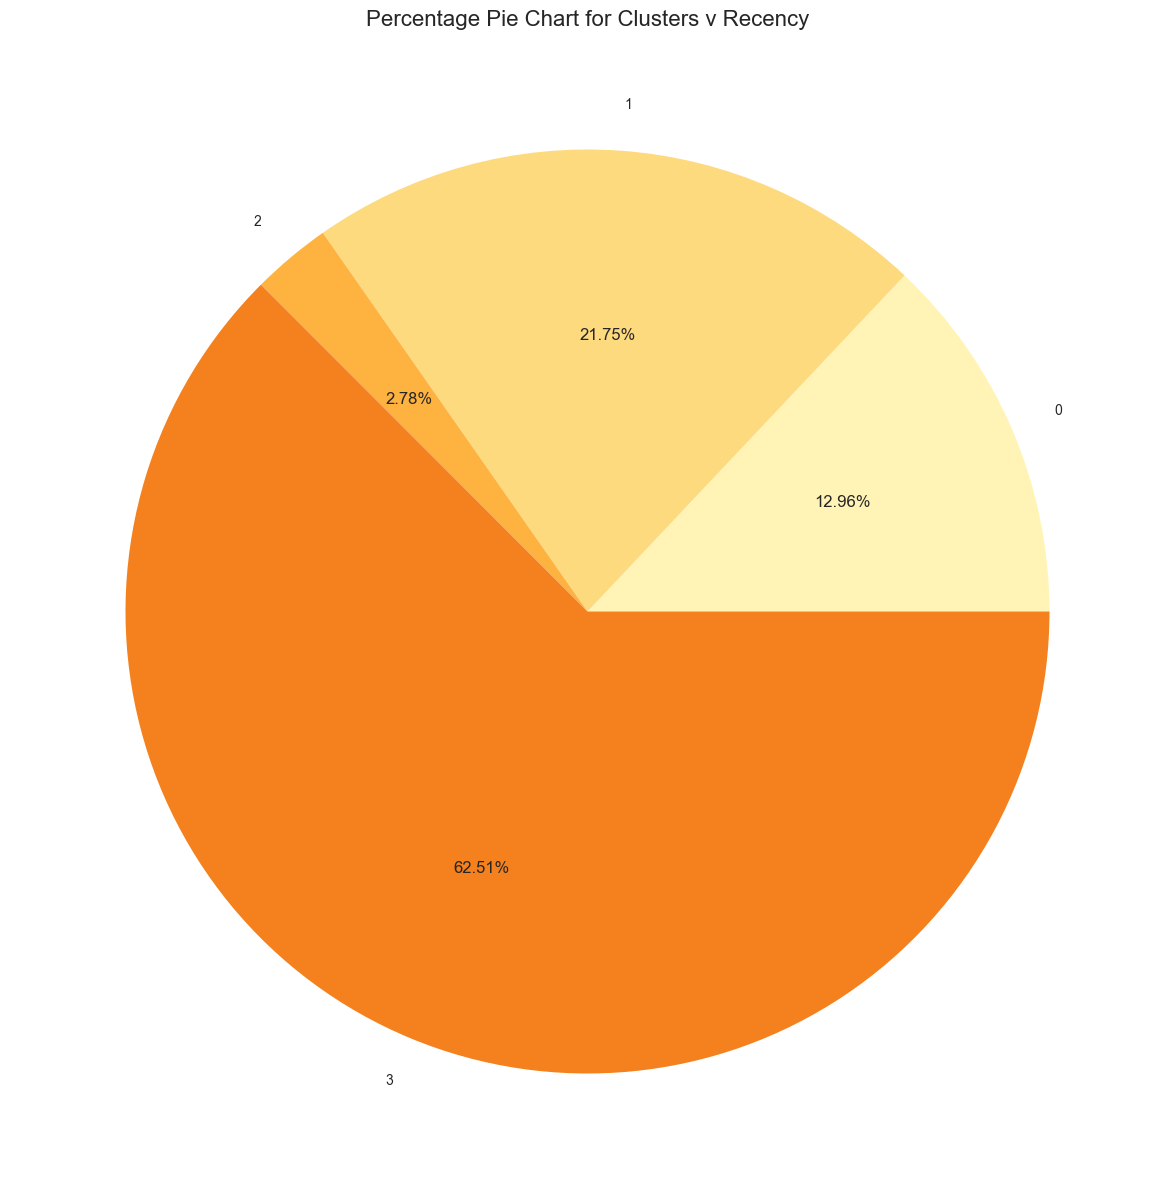

In [40]:
# Colour palette
palette_color = sns.color_palette('YlOrBr')

# Quantity per day of week
plt.pie(rfm_stats['Recency_Mean'], labels = rfm_stats.index , colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Clusters v Recency', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

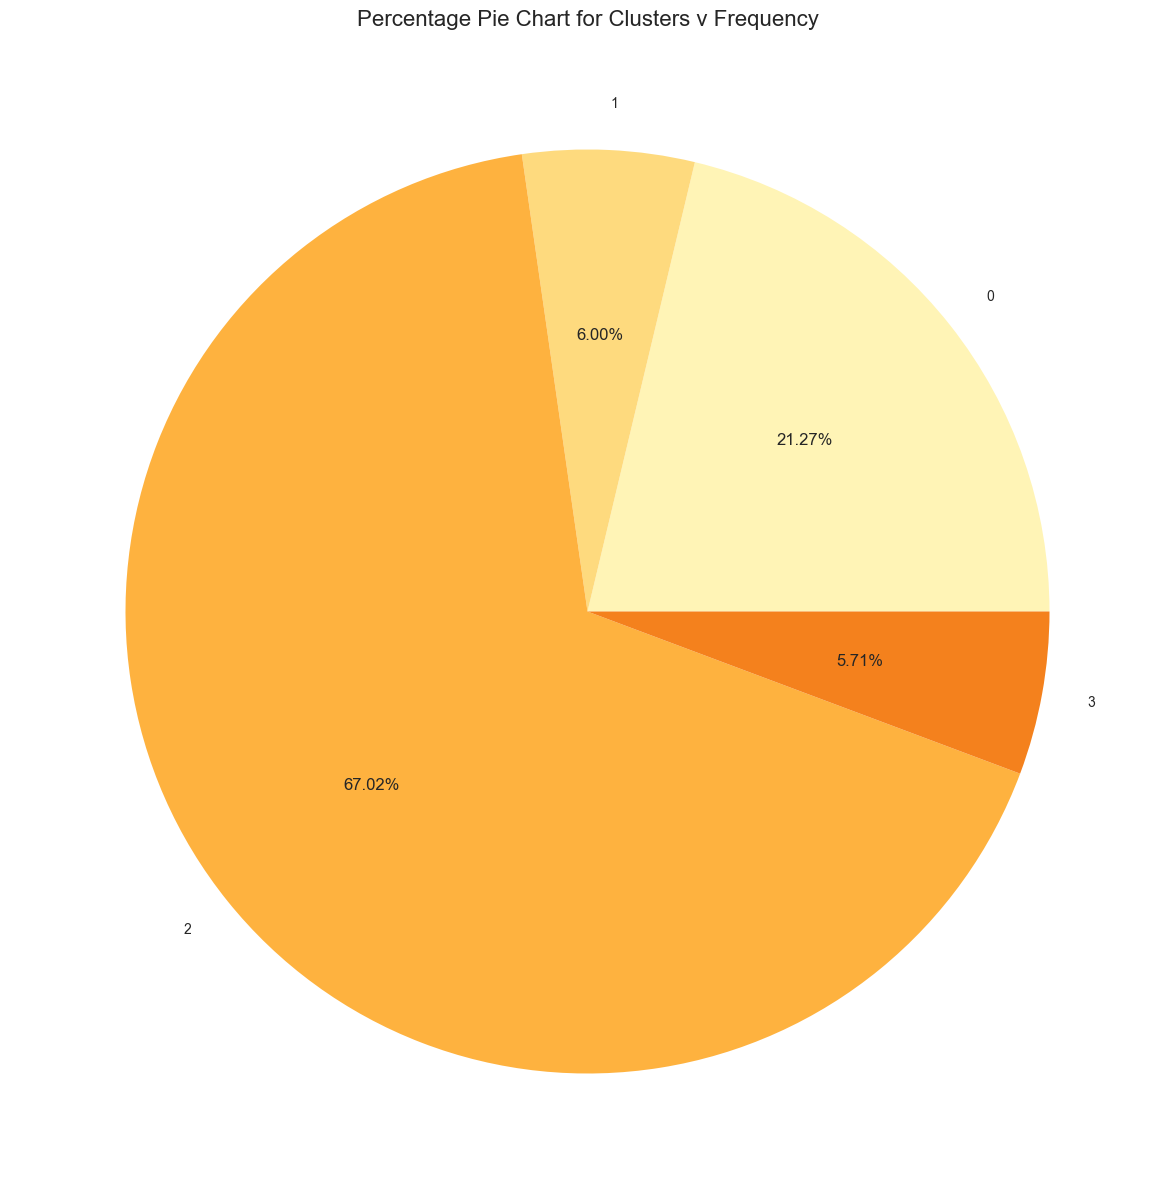

In [41]:
# Colour palette
palette_color = sns.color_palette('YlOrBr')

# Quantity per day of week
plt.pie(rfm_stats['Frequency_Mean'], labels = rfm_stats.index , colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Clusters v Frequency', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

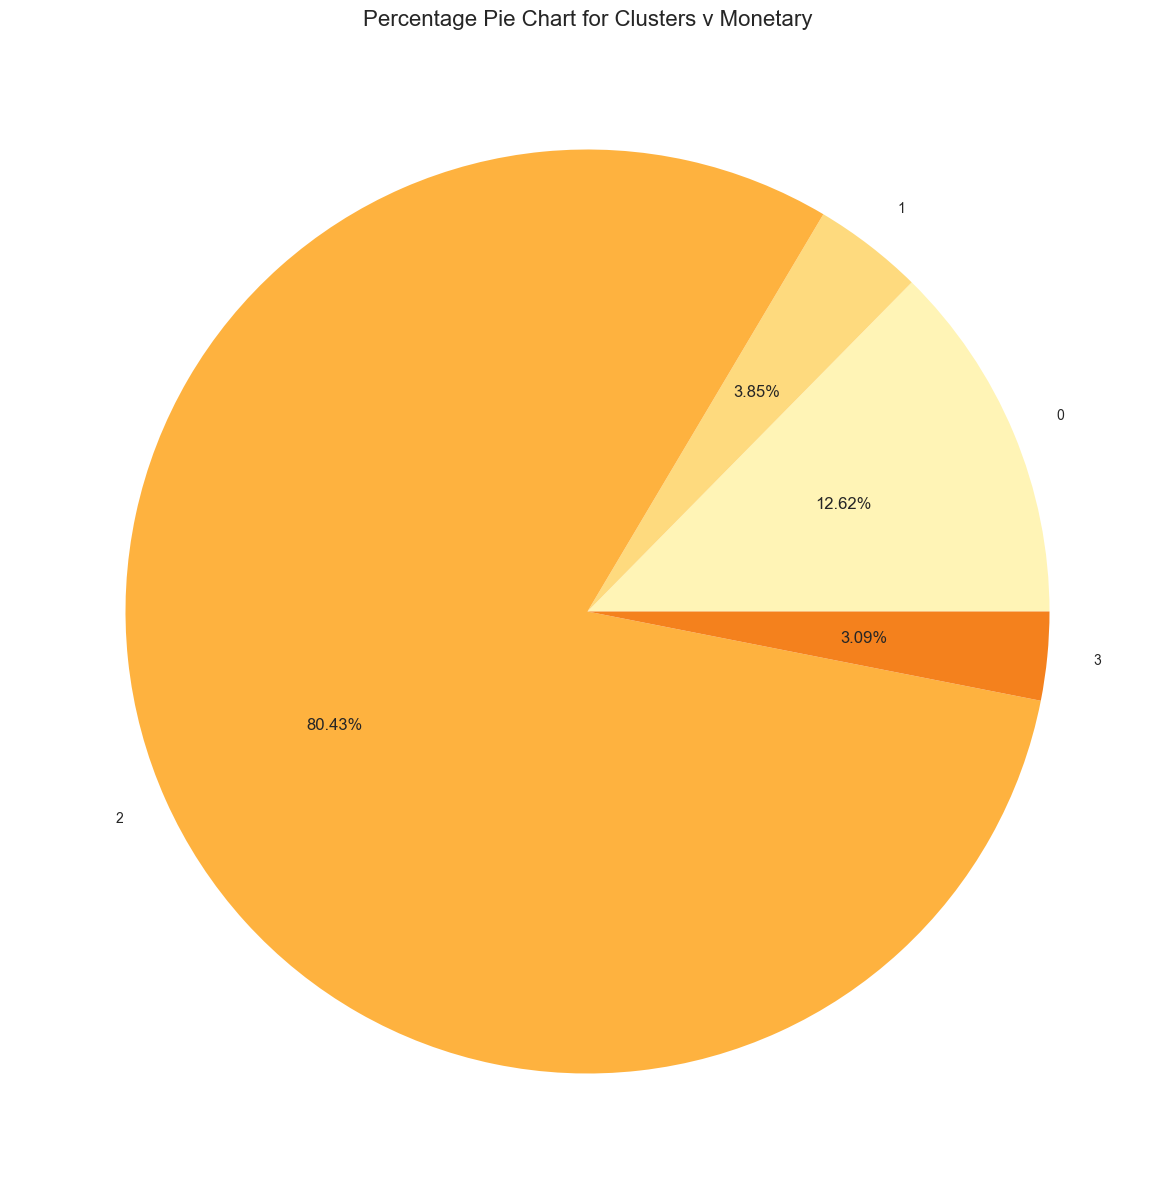

In [42]:
# Colour palette
palette_color = sns.color_palette('YlOrBr')

# Quantity per day of week
plt.pie(rfm_stats['Monetary_Mean'], labels = rfm_stats.index , colors=palette_color, autopct='%.02f%%')
plt.title('Percentage Pie Chart for Clusters v Monetary', fontsize=16)

# Displaying chart
fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

<Figure size 700x700 with 0 Axes>

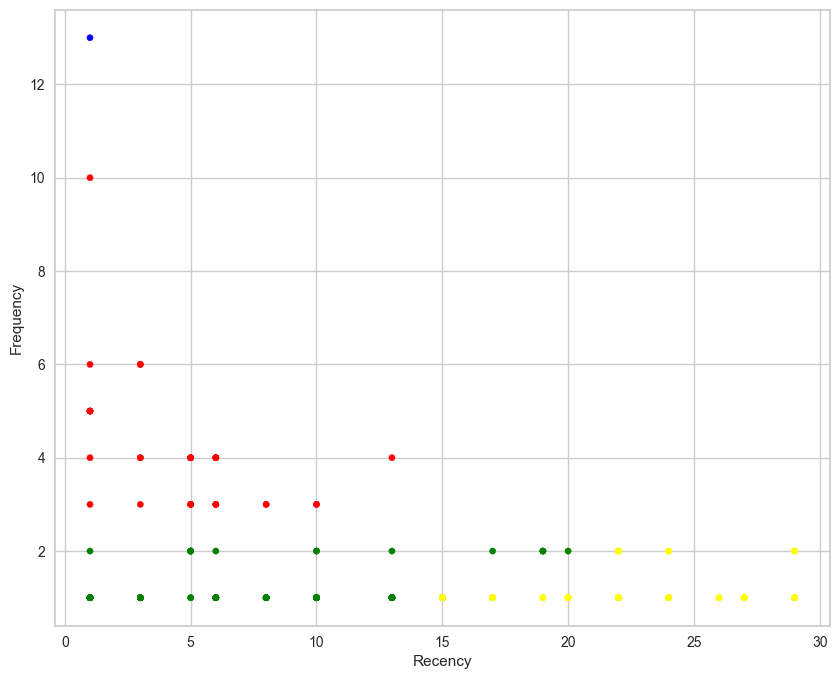

In [43]:
# Visualisasi hubungan antara Recency dan Frequency
# Membuat gambar dengan ukuran 7 x 7
plt.figure(figsize=(7,7))

# Mendefinisikan warna yang akan digunakan untuk mewarnai titik-titik dalam scater plot
Colors = ["red", "green", "blue", "yellow"]
# Menambahkan kolom Color ke Data Frame
rfm_scores['Color_Kmeans'] = rfm_scores['Clusters_Kmeans'].map(lambda p: Colors[p])
ax = rfm_scores.plot(    
    kind="scatter", 
    # Recency pada sumbu x dan frequency pada sumbu y
    x="Recency", y="Frequency",
    # Menentukan ukuran scatter plot
    figsize=(10,8),
    c = rfm_scores['Color_Kmeans']
)

In [44]:
rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Clusters_Kmeans,Color_Kmeans
CUSTOMER,,,,,,,,,,,
Bintang Hayam Wuruk po 00233,24,2,509000,4,2,2,422,8,Potential,3,yellow
Bintang Hayam Wuruk po 01602,17,2,509000,3,2,2,322,7,Potential,1,green
Bintang Hayam Wuruk po 03293,10,1,425000,2,4,4,244,10,Loyal,1,green
Bintang Hayam Wuruk po 05659,3,1,637500,1,4,2,142,7,Potential,1,green
Bintang Seminyak,3,3,1487500,1,1,1,111,3,Occasional,0,red


Observasi:

1. Cluster 0:
    - nnxjkhxk
    - bhjxkx

2. Cluster 1:
    - shuwks
    - dkwlw
    - hxwhnkx

3. Cluster 2:
    - dxiwl
    - kdhw

4. Cluster 3:
    - ishnk
    - ihxks

# 5. DBSCAN Clustering